In [1]:
# block 1 - import code libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import sympy as sp

In [2]:
# block 1A - represent the SC metric symbolically

def build_metric():
    # define symbolic variables for t, r, theta, phi
    t, r, theta, phi = sp.symbols('t r theta phi')
    
    # define metric functions symbolically
    f = sp.Function('f')(r)
    g = sp.Function('g')(r)
    h = sp.Function('h')(r)
    
    # build the Schwarzschild metric tensor
    metric = sp.Matrix([
        [-f, 0, 0, 0],                     
        [0, g, 0, 0],                     
        [0, 0, h, 0],                      
        [0, 0, 0, h * sp.sin(theta)**2]   
    ])
    
    return metric, (t, r, theta, phi)

# build the symbolic metric
metric_sym, coords = build_metric()

# print the metric tensor
print("Symbolic Metric Tensor:")
sp.pprint(metric_sym)
print(coords)

Symbolic Metric Tensor:
⎡-f(r)   0     0         0      ⎤
⎢                               ⎥
⎢  0    g(r)   0         0      ⎥
⎢                               ⎥
⎢  0     0    h(r)       0      ⎥
⎢                               ⎥
⎢                           2   ⎥
⎣  0     0     0    h(r)⋅sin (θ)⎦
(t, r, theta, phi)


In [3]:
# block 2 - Schwarzschild metric functions and constants
c = 1.0 # speed of light (normalized)
G = 1.0 # gravitational constant (normalized)

# function to get schwarzschild radius from mass
def rad_sc(M):
    return (2*G*M/c**2)

# schwarzschild functions (dependent on radial component, r, and Schwarzschild radius)
def f(r, M):
    return 1 - (2*G*M/(c**2*r))

def g(r, M):
    return (1 - 2*G*M/(c**2*r))**(-1)

def h(r):
    return r**2

In [61]:
# block 3 - functions to calculate effective potential (v_eff) & equations of motion for a particle in a SC spacetime

# effective potential
def v_eff(r, M, L, sigma=0):
    return -(f(r, M) * (sigma - (L**2 * h(r)**(-1))))

# tau - not accessed in this function - can be replaced by the affine parameter lambda for null geodesics
# equations of motion
def eq_of_motion(tau, y, params, sigma=0):

    t, r, phi = y
    E, L, M = params

    dt_dtau = E / f(r, M)
    dphi_dtau = L / h(r)
    dr_dtau = np.sqrt(g(r, M)**(-1) * (f(r, M)**(-1) * E**2 + (sigma - L**2 / h(r))))

    return [dt_dtau, dr_dtau, dphi_dtau]

In [5]:
# block 4 - assign values for parameters
M1 = 1.0  
rs1 = rad_sc(M1)
r1 = 10 * rs1

# conserved quantities (constants)
E1 = 1.1 # energy of orbiting particle
L1 = 4.0 # angular momentum of orbiting particle
L2 = 4.2
L3 = 4.4

# calculate and print SC metric components for the given radial distance from the BH and mass of the BH.
f1 = f(r1, M1)
g1 = g(r1, M1)
h1 = h(r1)

print(f"f(r) = {f1}")
print(f"g(r) = {g1}")
print(f"h(r) = {h1}")

f(r) = 0.9
g(r) = 1.1111111111111112
h(r) = 400.0


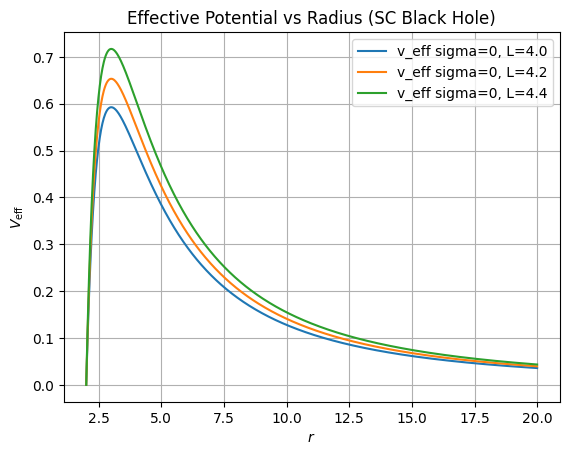

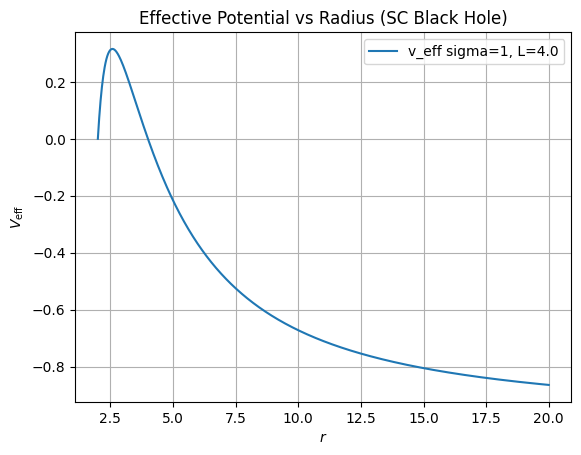

In [6]:
# block 5 - calculate v_eff as a function of radius given M (black hole mass), L (particles's angular momentum)
# span of r values
r_vals = np.linspace(rs1, r1, 1000)

# get list of effective potential values for sigma=0
v_eff_vals = np.array([v_eff(i, M1, L1, sigma=0) for i in r_vals])
v_eff_vals_L2 = np.array([v_eff(i, M1, L2, sigma=0) for i in r_vals])
v_eff_vals_L3 = np.array([v_eff(i, M1, L3, sigma=0) for i in r_vals])

# get list of effective potential values for sigma=1
v_eff_vals1 = np.array([v_eff(i, M1, L1, sigma=1) for i in r_vals])

# Plot the results sigma = 0
plt.plot(r_vals, v_eff_vals, label=f'v_eff sigma=0, L={L1}')
plt.plot(r_vals, v_eff_vals_L2, label=f'v_eff sigma=0, L={L2}')
plt.plot(r_vals, v_eff_vals_L3, label=f'v_eff sigma=0, L={L3}')
plt.xlabel(r'$r$')
plt.ylabel(r'$V_{\rm eff}$')
plt.title('Effective Potential vs Radius (SC Black Hole)')
plt.legend()
plt.grid(True)
plt.show()
# Plot the results sigma = 1
plt.plot(r_vals, v_eff_vals1, label=f'v_eff sigma=1, L={L1}')
plt.xlabel(r'$r$')
plt.ylabel(r'$V_{\rm eff}$')
plt.title('Effective Potential vs Radius (SC Black Hole)')
plt.legend()
plt.grid(True)
plt.show()


EXTREMA and LIMITS

Null Geodesics - sigma = 0
As r --> infinity
v_eff --> -(1 - 0) * (0 - 0) = 0 i.e. approaches 0 asymptotically

Time-like Geodesics - sigma = 1
As r --> infinity
v_eff --> -(1 - 0) * (1 - 0) = -1 i.e. approaches -1 asymptotically

Extrema for sigma=0:
r = 3.0090, V_eff = 0.5926

Extrema for sigma=1:
r = 2.5766, V_eff = 0.3155


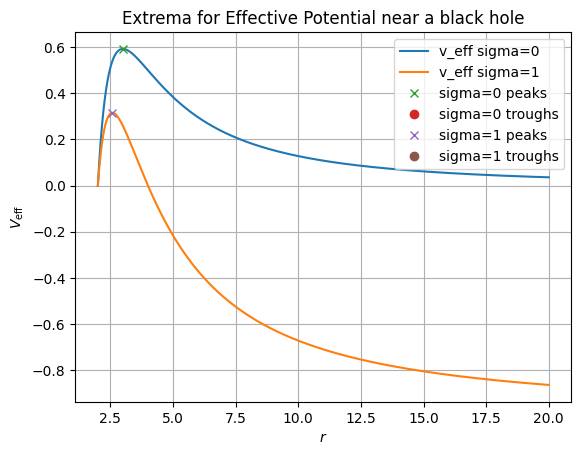

In [7]:
# block 6 - find extrema for effective potential for space around a Schwarzschild black hole
from scipy.signal import find_peaks

# find peaks for sigma=0, sigma=1
peaks1, _ = find_peaks(v_eff_vals)
peaks2, _ = find_peaks(v_eff_vals1)

# detect troughs (invert the function to find minima as peaks) for sigma=0, sigma=1
troughs1, _ = find_peaks(-v_eff_vals)
troughs2, _ = find_peaks(-v_eff_vals1)

# combine and sort extrema
extrema1 = np.sort(np.concatenate((peaks1, troughs1)))
extrema2 = np.sort(np.concatenate((peaks2, troughs2)))

# print extrema values for sigma=0 and sigma=1
print("Extrema for sigma=0:")
for j in extrema1:
    print(f"r = {r_vals[j]:.4f}, V_eff = {v_eff_vals[j]:.4f}")

print("\nExtrema for sigma=1:")
for k in extrema2:
    print(f"r = {r_vals[k]:.4f}, V_eff = {v_eff_vals1[k]:.4f}")

plt.plot(r_vals, v_eff_vals, label='v_eff sigma=0')
plt.plot(r_vals, v_eff_vals1, label='v_eff sigma=1')
plt.plot(r_vals[peaks1], v_eff_vals[peaks1], 'x', label='sigma=0 peaks')
plt.plot(r_vals[troughs1], v_eff_vals[troughs1], 'o', label='sigma=0 troughs')
plt.plot(r_vals[peaks2], v_eff_vals1[peaks2], 'x', label='sigma=1 peaks')
plt.plot(r_vals[troughs2], v_eff_vals1[troughs2], 'o', label='sigma=1 troughs')
plt.xlabel(r'$r$')
plt.ylabel(r'$V_{\rm eff}$')
plt.title('Extrema for Effective Potential near a black hole')
plt.legend()
plt.grid(True)
plt.show()

In [76]:
# block 7 - solve for r(phi) and make a polar plot
# define dr/dphi function for integration
def solve_r_phi(params, phi_range, r_init, sigma=0):
    """
    Solve for r as a function of phi using solve_ivp.
    
    Parameters:
    params : list
        [E, L, M] where E is energy, L is angular momentum, and M is mass.
    phi_range : tuple
        (phi_start, phi_end) range for integration.
    r_init : float
        Initial radial distance.
    sigma : int, optional
        Value for sigma (default is 0).
    
    Returns:
    sol : OdeSolution
        Solution object from solve_ivp.
    """
    E, L, M = params  # unpack parameters
    
    def dr_dphi(phi, y):
        r = y[0]
        epsilon = 1e-6
        
        # stop integration if r is out of bounds
        if r <= rs1 + epsilon or r >= r_max:
            return [0] 
        
        hr = h(r)
        fr = f(r, M)
        gr = g(r, M)
        dr_dphi = (hr / L) * np.sqrt(max(0, 1 / gr * (E**2 / fr + (sigma - L**2 / hr))))
        return [dr_dphi]
    
    # Solve the ODE
    sol = solve_ivp(dr_dphi, phi_range, [r_init], t_eval=np.linspace(*phi_range, 1000), atol=1e-6, rtol=1e-6)
    return sol

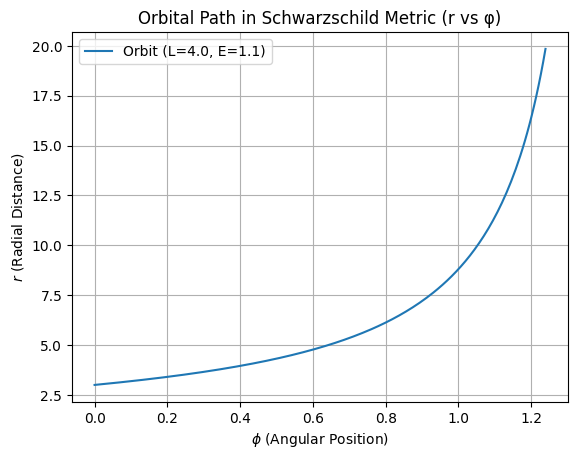

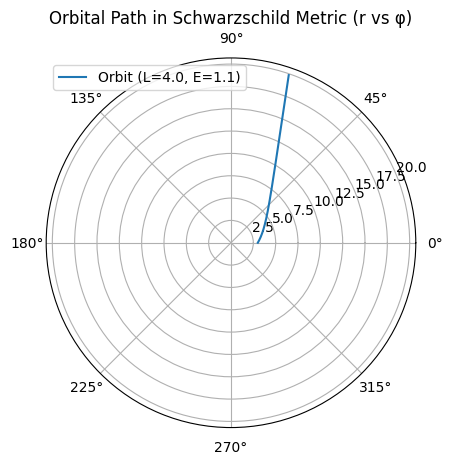

In [78]:
# Block 8
# code to integrate dr_dphi and display as a polar plot

# initial conditions
phi_range = (0, 2 * np.pi)
r_init = 1.5 * rs1 
params = [E1, L1, M1]
r_max = 10 * rs1
sol_r_phi = solve_r_phi(params, phi_range, r_init)

# extract solution
phi_vals = sol_r_phi.t
r_vals = sol_r_phi.y[0]
valid_indices = r_vals <= r_max
phi_vals = phi_vals[valid_indices]
r_vals = r_vals[valid_indices]

# Plot r vs φ
plt.plot(phi_vals, r_vals, label=f'Orbit (L={L1}, E={E1})')
plt.xlabel(r'$\phi$ (Angular Position)')
plt.ylabel(r'$r$ (Radial Distance)')
plt.title('Orbital Path in Schwarzschild Metric (r vs φ)')
plt.legend()
plt.grid(True)
plt.show()

# Polar plot
plt.polar(phi_vals, r_vals, label=f'Orbit (L={L1}, E={E1})')
plt.title('Orbital Path in Schwarzschild Metric (r vs φ)')
plt.legend()
plt.grid(True)
plt.show()

In [69]:
# block 9 - solver to compute r(lambda), phi(lambda)

# solve for r and phi as a function of tau using eq_of_motion
def solve_r_phi_tau(params, tau_range, r_init, phi_init, sigma=0):

    E, L, M = params

    # initial conditions [t, r, phi]
    y0 = [0, r_init, phi_init]  

    def dy_dt(tau, y):
        # get ODE's from eq_of_motion function
        dt_dtau, dr_dtau, dphi_dtau = eq_of_motion(tau, y, params, sigma)

        return [dt_dtau, dr_dtau, dphi_dtau]

    # solve for r(lambda) and phi(lambda)
    sol = solve_ivp(dy_dt, tau_range, y0, t_eval=np.linspace(*tau_range, 1000), atol=1e-6, rtol=1e-6)
    return sol


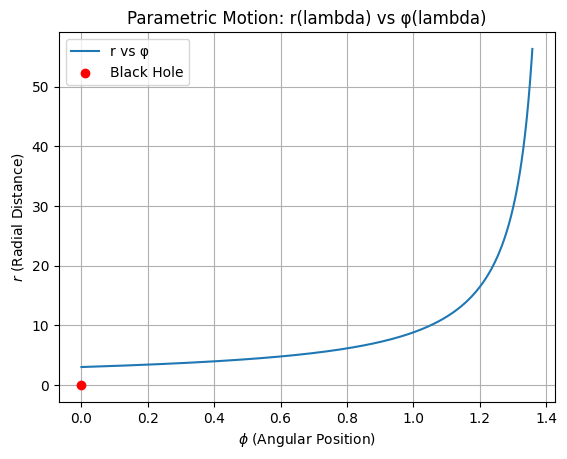

In [68]:
# block 10 
# initial conditions / constants
r_init = 1.5 * rs1  
params = [E1, L1, M1]

# solve for r(t) and phi(t)
tau_range = [0, 50]
phi_init = 0

if E1**2 <= v_eff(r_init, M1, L1):
    print("Energy is too low for a valid orbit")

sol_y = solve_r_phi_tau(params, tau_range, r_init, phi_init, sigma=0)

if not sol_y.success:
    print("Integration failed:", sol_y.message)

# get results for r(tau) and phi(tau)
r_vals2 = sol_y.y[1]  # radial distances
phi_vals2 = sol_y.y[2]  # angular positions

# parametric plot: r(tau) vs phi(tau)
plt.plot(phi_vals2, r_vals2, label=f'r vs φ')
plt.scatter([0], [0], color='red', label='Black Hole', zorder=5)
plt.xlabel(r'$\phi$ (Angular Position)')
plt.ylabel(r'$r$ (Radial Distance)')
plt.title('Parametric Motion: r(lambda) vs φ(lambda)')
plt.legend()
plt.grid(True)
plt.show()